In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, fit_and_score_pipeline, exp_range, \
    validation_curve_with_undersampling, plot_validation_curve_with_undersampling
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import fbeta_score, make_scorer

In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0


# data = data[~np.isnan(data).any(axis=1)]
print(data[:,-1])

print(f'data.shape={data.shape}')

X, y = data[:,:-1], data[:, -1]
# X, y, idx = balanced_sampling(X, y, r = 3, random_state=42)

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y.astype(str))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f'X.shape={X.shape}, y.shape={y.shape}')

[0. 0. 0. ... 1. 1. 1.]
data.shape=(43405, 65)
X.shape=(43405, 64), y.shape=(43405,)


In [4]:

def fit_and_score_iteratively(classifier, X, y, undersampling_ratio, iterations):
    results = []

    for i in range(iterations):    
        X_, y_, idx = balanced_sampling(X, y, r = undersampling_ratio, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

        classifier.fit(X_train, y_train)

        scorer = check_scoring(classifier, scoring='accuracy')
        score_a = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='f1')
        score_f1 = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='recall')
        score_r = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='precision')
        score_p = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='balanced_accuracy')
        score_ba = scorer(classifier, X_test, y_test)

        results.append((score_a, score_f1, score_p, score_r, score_ba))

    return np.mean(np.array(results), axis=0)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
classifier = MLPClassifier(solver='sgd', alpha=1e-4, hidden_layer_sizes=(30, 15), random_state=0, 
                           learning_rate_init = 0.002, max_iter=2000)
pipe = make_pipeline(StandardScaler(), classifier)
res = fit_and_score_iteratively(pipe, X_train, y_train, 1, 1)
res

a=0.0, r=1, gamma=20.040858725761773


iteration 1
a=0.0, r=1, gamma=19.758010521281683
iteration 2
a=0.0, r=1, gamma=19.758010521281683


<module 'matplotlib.pyplot' from '/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/matplotlib/pyplot.py'>

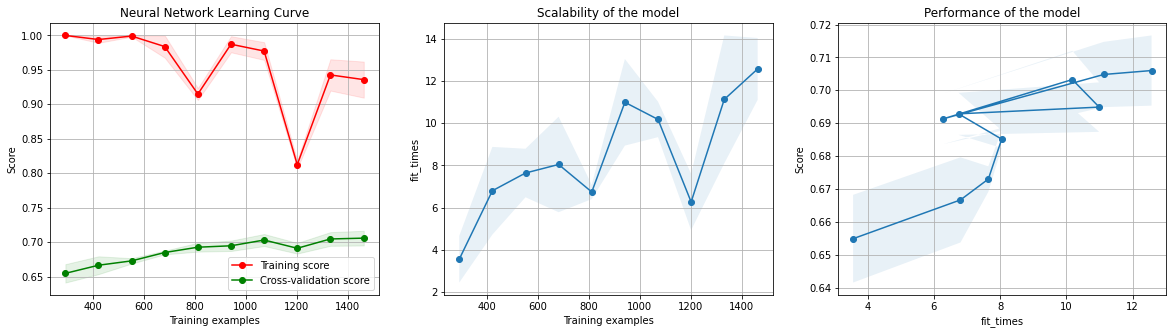

In [14]:

# pipe.fit(X_train, y_train)  # apply scaling on training data
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu',
                           alpha=1e-4, hidden_layer_sizes=(30, 15), random_state=0, 
                           learning_rate_init = 0.001, max_iter=2000)
pipe = make_pipeline(StandardScaler(), classifier)

title = 'Neural Network Learning Curve'
plot_learning_curve(pipe, title, X, y, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.2, 1.0, 10), scoring='accuracy', iterations=2)